In [15]:
# Check CUDA Availability

import torch
assert torch.cuda.is_available()

In [19]:
# Import and Reload All Modules

from importlib import reload
from model import binarize, bsnn, config, dataset, trainer

from tonic.datasets import DVSGesture
from tonic.transforms import Compose, Denoise, Downsample, ToFrame
from tonic.utils import plot_animation
from IPython.display import HTML


reload(binarize)
reload(bsnn)
reload(config)
reload(dataset)
reload(trainer)

should_log_outputs = True

In [20]:
# Load Configurations

TRAIN_CONFIG = config.DEFAULT_BSNN_CONFIG_VALUES
LOADER_CONFIG = config.DEFAULT_LOADER_CONFIG_VALUES

if should_log_outputs:
    print("Train Configuration:")
    for idx, (key, value) in enumerate(TRAIN_CONFIG.items()):
        print(f"\t{idx:02d}. {key}: {value}")

    print("\nLoader Configuration:")
    for idx, (key, value) in enumerate(LOADER_CONFIG.items()):
        print(f"\t{idx:02d}. {key}: {value}")

Train Configuration:
	00. num_blocks: 2
	01. base_width: 8
	02. base_factor: 2
	03. pool_kernel_size: 2
	04. pool_stride_size: 2
	05. conv_kernel_size: 5
	06. conv_stride_size: 1
	07. conv_padding_size: 0
	08. conv_dilation_size: 1
	09. num_classes: 10
	10. img_height: 32
	11. img_width: 32
	12. img_num_frames: 32
	13. frame_filter_threshold: 10000
	14. num_epochs: 500
	15. num_trials: 100
	16. num_steps: 100
	17. beta_value: 0.41628667820177095
	18. beta_range: [0.9, 0.99]
	19. thresholds: [22.37297929074331, 1.738555820352834, 19.083022150261986]
	20. dropout: 0.48143584931131816
	21. slope: 0.9870918226886212
	22. correct_rate: 0.8
	23. incorrect_rate: 0.2
	24. is_batch_norm: False

Loader Configuration:
	00. data_path: ./train/DVSGesture
	01. data_cache_path: ./cache/DVSGesture
	02. label_csv_path: ./train/DVSGesture/gesture_mapping.csv
	03. batch_size: 32
	04. use_data_cache: True


In [22]:
# Load Dataset and Labels

transforms = Compose([
    Denoise(filter_time=TRAIN_CONFIG['frame_filter_threshold']),
    Downsample(sensor_size=DVSGesture.sensor_size, target_size=(TRAIN_CONFIG['img_height'], TRAIN_CONFIG['img_width'])),
    ToFrame(sensor_size=(TRAIN_CONFIG['img_height'], TRAIN_CONFIG['img_width'], 2), n_time_bins=TRAIN_CONFIG['img_width']), 
])

train, test, labels = dataset.load(LOADER_CONFIG)
train = dataset.to_cache(LOADER_CONFIG, train)
test = dataset.to_cache(LOADER_CONFIG, test)

if should_log_outputs:
    print(f"\nTrain Data: {train} ({len(train)})")
    print(f"Test Data: {test} ({len(test)})")
    
    print(f"Labels:")
    for idx, label in enumerate(labels):
        print(f"\t{idx:02d}. {label}")


Train Data: DiskCachedDataset(dataset=DVSGesture, cache_path='./cache/DVSGesture', reset_cache=False, transform=None, target_transform=None, transforms=None, num_copies=1, compress=True) (1077)
Test Data: DiskCachedDataset(dataset=DVSGesture, cache_path='./cache/DVSGesture', reset_cache=False, transform=None, target_transform=None, transforms=None, num_copies=1, compress=True) (264)
Labels:
	00. None
	01. hand_clapping
	02. right_hand_wave
	03. left_hand_wave
	04. right_arm_clockwise 
	05. right_arm_counter_clockwise 
	06. left_arm_clockwise 
	07. left_arm_counter_clockwise 
	08. arm_roll
	09. air_drums
	10. air_guitar
	11. other_gestures


Sample
	01. Event Count: 213025
	02. Frame Shape: (100, 2, 128, 128)


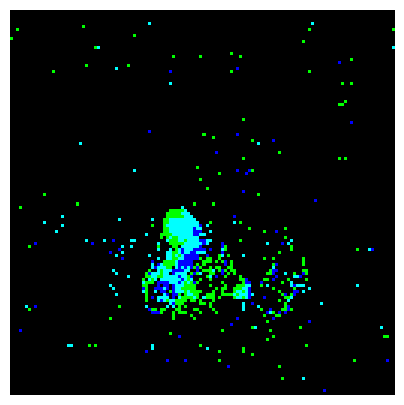

In [24]:
# Show Samples

if should_log_outputs:
    events, label = train[0]
    frames = dataset.to_frames(events)
    
    print("Sample")
    print("\t01. Event Count:", len(events))
    print("\t02. Frame Shape:", frames.shape)

    frames = dataset.normalize_frames(frames)
    animation = plot_animation(frames).to_jshtml()
    HTML(animation)

In [28]:
# Model Loading

from importlib import reload
from model import bsnn

reload(bsnn)

BSNN_CONFIG = {
    'num_blocks': 2,
    'num_classes': num_classes,
    'img_dimension': 32,
}

model = bsnn.BSNN(config=BSNN_CONFIG)
print(model)

BSNN(
  (layers): Sequential(
    (conv0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu0): Leaky()
    (conv1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu1): Leaky()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (output): Linear(in_features=400, out_features=11, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (leaky_out): Leaky()
  )
)


In [ ]:
# Training

from importlib import reload
from model import train

reload(train)

TRAIN_CONFIG = {
    'num_steps': 15,
    'num_epochs': 50,
    'learning_rate': 0.0001,
    'thresholds': [2, 2, 3],
    'activation_threshold': 0.4,
}

assert(len(TRAIN_CONFIG['thresholds']) == BSNN_CONFIG['num_blocks'])

